In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Datasets/synthetic_fraud_detection.csv")

df = df.dropna()
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


### About the Dataset
This dataset is from Kaggle and can be found at this [link](https://www.kaggle.com/ntnu-testimon/paysim1). It is synthetic financial transaction data generated from using Paysim using real world financial transactions.

### Questions
- How often are fraudulent transactions happening?
- What types of transactions are most often fraudulent?
- What amounts are typically moved fraudulently?
- Does the time step affect the amount of money the agent attempts to move fraudulently?
- What is the best way to determine transaction fraud from the data given?
- What features matter most what determining fraud?

#### What is the distribution of each transaction type

In [76]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [77]:
df['type'].value_counts(normalize=True)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

#### How many fraudulent transactions are included in the transactions above?

In [78]:
len(df[df['isFraud'] == 1])

8213

In [79]:
len(df[df['isFraud'] == 1])/len(df)

0.001290820448180152

#### What types of transactions are the most common out of fraudulent transactions?

In [80]:
df[df['isFraud'] == 1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

#### What amounts are typically fraudulently moved?

In [81]:
df[df['isFraud'] == 1]['amount'].min()

0.0

In [82]:
df[df['isFraud'] == 1]['amount'].max()

10000000.0

In [83]:
df[df['isFraud'] == 1]['amount'].mean()

1467967.299140387

In [84]:
df[df['isFraud'] == 1]['amount'].std()

2404252.947240169

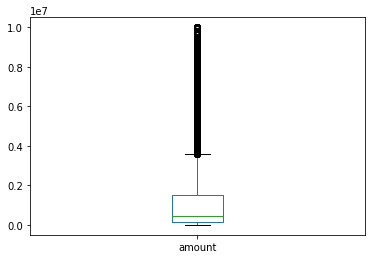

In [85]:
df[df['isFraud'] == 1]['amount'].plot.box()

#### Did the time step affect how much money the agent would try to move

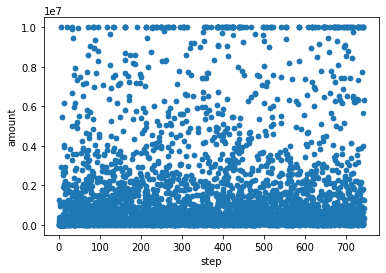

In [86]:
temp_df = df[df['isFraud'] == 1]

temp_df.plot.scatter(x='step', y='amount')

#### From this graph, the time step did not affect how much money the agent tried to move
The reason the majority of fraudulant transfers are below 200,000 is because the environement was set up to automatically flag all transfers over 200,000 as fraud

In [87]:
from sklearn.model_selection import train_test_split

X = df[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Try logistic regression vs decision tree vs Naive Bayes

In [88]:
#### function to get necessary metrics
from sklearn.metrics import confusion_matrix


def get_metrics(confusion):
    acc = (confusion[0][0] + confusion[1][1])/(confusion[0][0] + confusion[1][1] + confusion[0][1] + confusion[1][0])
    
    prec = (confusion[1][1])/(confusion[1][1] + confusion[1][0])
    
    recall = (confusion[1][1])/(confusion[1][1] + confusion[0][1])
    
    clas = (confusion[0][1] + confusion[1][0])/(confusion[0][1] + confusion[1][1] + confusion[0][1] + confusion[1][0])
    
    spec = (confusion[0][0])/(confusion[0][0] + confusion[0][1])
    
    f1 = 2*((prec*recall)/(prec+recall))
    
    print("acc: " + str(acc))
    print("prec: " + str(prec))
    print("recall: " + str(recall))
    print("clas: " + str(clas))
    print("spec: " + str(spec))
    print("f1: " + str(f1))
    return acc, prec, recall, clas, spec, f1

In [89]:
#### logistic regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

logreg_matrix = confusion_matrix(y_test, y_pred)

logreg_acc, logreg_prec, logreg_recall, logreg_clas, logreg_spec, logreg_f1 = get_metrics(logreg_matrix)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc: 0.9993152715914723
prec: 0.6633333333333333
recall: 0.7613582018173123
clas: 0.38463802236609773
spec: 0.9997382481826871
f1: 0.7089735025606769


In [90]:
#### Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dec_tree = DecisionTreeClassifier(criterion='entropy')

dec_tree.fit(X_train, y_train)

y_pred = dec_tree.predict(X_test)

decision_tree_matrix = confusion_matrix(y_test, y_pred)

decision_tree_acc, decision_tree_prec, decision_tree_recall, decision_tree_clas, decision_tree_spec, decision_tree_f1 = get_metrics(decision_tree_matrix)

acc: 0.999648467664788
prec: 0.855
recall: 0.864
clas: 0.22028890347997374
spec: 0.9998305694649458
f1: 0.8594764397905759


In [91]:
#### Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb = MultinomialNB()

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

NB_acc, NB_prec, NB_recall, NB_clas, NB_spec, NB_f1 = get_metrics(confusion_matrix(y_test, y_pred))




acc: 0.6292035880397279
prec: 0.8479166666666667
recall: 0.00286845558686346
clas: 0.499410815036847
spec: 0.62892824433247
f1: 0.005717568951493381


### Compare Results

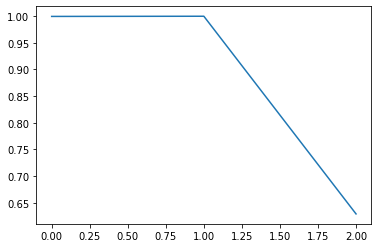

In [92]:
plt.plot([logreg_acc, decision_tree_acc, NB_acc])

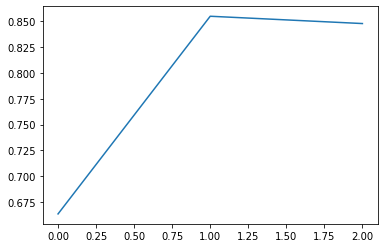

In [93]:
plt.plot([logreg_prec, decision_tree_prec, NB_prec])

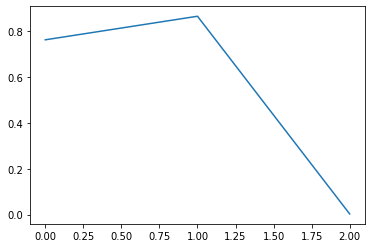

In [94]:
plt.plot([logreg_recall, decision_tree_recall, NB_recall])

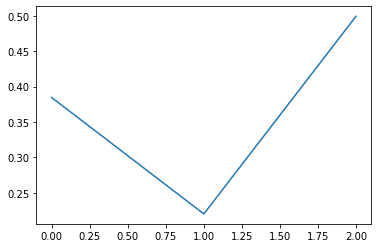

In [95]:
plt.plot([logreg_clas, decision_tree_clas, NB_clas])

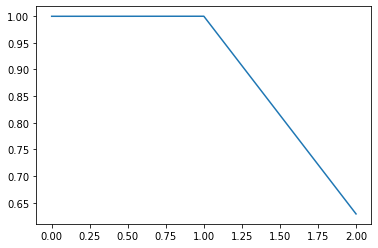

In [96]:
plt.plot([logreg_spec, decision_tree_spec, NB_spec])

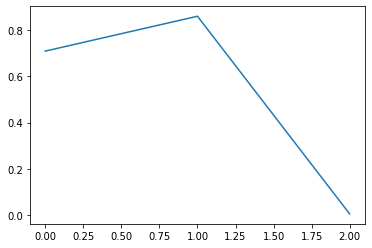

In [97]:
plt.plot([logreg_f1, decision_tree_f1, NB_f1])

From the graphs above, it is easy to see the decision tree performed the best with the highest in 5 of the metrics and the lowest in classification error(which is what you want)

Classifier | Accuracy | Precision | Recall | Clas. Error | Spec | F1
--- | --- | --- | --- | --- | --- | ---
Logistic Regression | 0.998 | 0.4418 | 0.377 | 0.5237 | 0.9991 | 0.407
Decision Tree | 0.9996 | 0.836 | 0.858 | 0.236 | 0.9998 | 0.8472
Naive Bayes | 0.6175 | 0.8627 | 0.0029 | 0.4994 | 0.617 | 0.00572

### Let's take a closer look at the decision tree

#### What features are the most important when it comes to classifing fraud or not?

In [98]:
dec_tree.feature_importances_

array([0.04671537, 0.26204276, 0.50152337, 0.08436475, 0.01500533,
       0.09034841])

In [99]:
feature_imp = pd.Series(dec_tree.feature_importances_,index=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']).sort_values(ascending=False)
feature_imp


oldbalanceOrg     0.501523
amount            0.262043
newbalanceDest    0.090348
newbalanceOrig    0.084365
step              0.046715
oldbalanceDest    0.015005
dtype: float64

In [100]:
dec_tree.get_depth()

32

### Conclusion

From the models above, a decision tree outperformed the others on nearly all the metrics. 